In [65]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import math
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
import matplotlib.colors as colors
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import sympy
sympy.init_printing()
from IPython.display import Math
plt.style.use("default")


In [66]:
date = '20220613'
# dataNo = 2
scanNo = 1

In [67]:
path = r"./"+date
# path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [68]:
score_name = 'N2*N2/N1 @ ROI1 (arb. u.)'
score = scan_data[score_name]
sortedData = scan_data.sort_values(by=score_name, ascending=False)
print(sortedData)

      #No.  Log No.  Total count1 @ ROI1 (arb. u.)  \
365    365      146                    105012413.0   
494    494      273                     78721271.0   
407    407      187                    104703599.0   
288    288       69                     97693639.0   
635    635      414                     99892085.0   
...    ...      ...                            ...   
930    930      708                       -87907.0   
908    908      687                        -9953.0   
1019  1019      796                        -6088.0   
995    995      772                        -3976.0   
994    994      771                        -6561.0   

      Total count1 @ ROI1 std. (arb. u.)  Total count2 @ ROI1 (arb. u.)  \
365                                  0.0                    167195117.0   
494                                  0.0                    138821251.0   
407                                  0.0                    158734434.0   
288                                  0.0           

In [69]:
max_count=sortedData[score_name].iloc[0]
print(max_count)

266199074.471736


In [70]:
dataAbove80PercentOfMaxScore = sortedData[sortedData[score_name] > 0.80*max_count]
print(len(dataAbove80PercentOfMaxScore))

23


## Intensity Calculation

### Optical pumping beams

#### OP1

In [71]:
w0_OP1 = 1.665*1e-3 #[m] Beam waist
gradient_OP1 = 57.7*1e-6 #[W/V] inclination of linear fit to OP1 AM vs CTRL voltage
offset_OP1 = -0.75*1e-6 #[W/V] offset of linear fit to OP1 AM vs CTRL voltage

#### OP2

In [72]:
w0_OP2 = 1.665*1e-3 #[m] Beam waist
gradient_OP2 = 57.7*1e-6 #[W/V] inclination of linear fit to OP1 AM vs CTRL voltage
offset_OP2 = -0.75*1e-6 #[W/V] offset of linear fit to OP1 AM vs CTRL voltage

### Raman beams

#### Constants

In [73]:
c = 2.99792458*1e8         # [m/s] Speed of light
epsilon_0 = 8.854187*1e-12 # [F/m] Permittivity of Vacuum
hbar = 1.054571*1e-34      # [rad^-1 J s] Reduced Plank's constant
jdj = 2.5377*1e-29         # [C m] Reduced dipole matrix element for D1 transition of 87Rb

#### Transition parameters

##### G11

In [74]:
f = 2       # Total angular momentum for initial state
fe = 2      # Total angular momentum for intermediate state
mf = -2     # Magnetic sublevel for initial state
mfe = -2    # Magnetic sublevel for intermediate state
j = 1/2     # Angular momentum for initial state
je = 1/2    # Angular momentum for intermediate state
nuc = 3/2   # Nuclear spin for 87 Rb
q = 0       # Polarization of light
g11 = (-1)**(2*fe+j+nuc+mf)*np.sqrt((2*f+1)*(2*fe+1)*(2*j+1))*float(wigner_3j(fe,1,f,mfe,q,-mf)*wigner_6j(j,je,1,fe,f,nuc))

##### G22

In [75]:
f = 1       # Total angular momentum for initial state
fe = 2      # Total angular momentum for intermediate state
mf = -1     # Magnetic sublevel for initial state
mfe = -2    # Magnetic sublevel for intermediate state
j = 1/2     # Angular momentum for initial state
je = 1/2    # Angular momentum for intermediate state
nuc = 3/2   # Nuclear spin for 87 Rb
q = 1       # Polarization of light
g22 = (-1)**(2*fe+j+nuc+mf)*np.sqrt((2*f+1)*(2*fe+1)*(2*j+1))*float(wigner_3j(fe,1,f,mfe,q,-mf)*wigner_6j(j,je,1,fe,f,nuc))

#### Beam parameters

In [76]:
delta = 2*np.pi*105*1e9     # [rad s^-1] Detuning of Raman beams from the intermediate state
wavelength = 795*1e-9       # [m] Wavelength of Raman beams

### Raman 1 (D)

In [77]:
w0R1D = 1.25*1e-3                   # [m] Beai waist @ fiber output
zr = np.pi*w0R1D**2/wavelength      # [m] Raleigh length
z = 1                               # [m] Distance from a spot
w0_R1D = w0R1D*np.sqrt(1+z**2/zr**2)    # [m] Beam waist @ atoms
gradient_R1D = 4.14*1e-3 #[W/V] inclination of linear fit to R1D AM vs CTRL voltage
offset_R1D = -0.147*1e-3 #[W/V] offset of linear fit to R1D AM vs CTRL voltage


### Raman 1 (H)

In [78]:
w0_R1H = np.sqrt(0.381*0.343)*1e-3   # [m] Beam waist @ atoms
gradient_R1H = 0.25*1e-3 #[W/V] inclination of linear fit to R1H AM vs CTRL voltage
offset_R1H = -0.026*1e-3 #[W/V] offset of linear fit to R1H AM vs CTRL voltage

### Raman 2

In [79]:
w0_R2 = np.sqrt(0.111*0.081)*1e-3    # [m] Beam waist @ atoms
gradient_R2 = 3.2*1e-3 #[W/V] inclination of linear fit to R2 AM vs CTRL voltage
offset_R2 = 0.191*1e-3 #[W/V] offset of linear fit to R2 AM vs CTRL voltage

In [80]:
def voltage_to_intensity(voltage, gradient, offset, w0):
    power = gradient*voltage+offset #[W]
    intensity = 2*power/(np.pi*w0**2)
    return intensity

def intensity_to_RabiFrequency(intensity_R1, intensity_R2):
    meanIntensity = np.sqrt(np.abs(intensity_R1*intensity_R2))
    electricFieldStrength = np.sqrt(2*meanIntensity/(c*epsilon_0))
    rabiFrequency =  1/(2*np.pi)*jdj**2/(2*delta*hbar**2)*electricFieldStrength**2*np.abs(g11*g22)*1e-3
    return rabiFrequency

## Detuning Calculation

### OP1

In [81]:
resonance_OP1 = 78.94+0.64 # [MHz] RF frequency corresponding to resoance
gradient_FM_OP1 = 4.05 #[MHz/V] inclination of linear fit to OP1 FM vs CTRL voltage
offset_FM_OP1 = 42.1 #[MHz/V] offset of linear fit to OP1 FM vs CTRL voltage

### OP2

In [82]:
resonance_OP2 = 108.30+1.36 # [MHz] RF frequency corresponding to resoance
gradient_FM_OP2 = 15.5 #[MHz/V] inclination of linear fit to OP2 FM vs CTRL voltage
offset_FM_OP2 = 37.8 #[MHz/V] offset of linear fit to OP2 FM vs CTRL voltage

### Raman 1 (D)

In [83]:
resonance_R1D = 80.012 # [MHz] RF frequency corresponding to resoance
gradient_FM_R1D = 0.0231 #[MHz/V] inclination of linear fit to R1D FM vs CTRL voltage
offset_FM_R1D = 80 #[MHz/V] offset of linear fit to R1D FM vs CTRL voltage

### Raman 1 (H)

In [84]:
resonance_R1H = 80.003 # [MHz] RF frequency corresponding to resoance
gradient_FM_R1H = 0.0227 #[MHz/V] inclination of linear fit to R1H FM vs CTRL voltage
offset_FM_R1H = 80 #[MHz/V] offset of linear fit to R1H FM vs CTRL voltage

In [85]:
def voltage_to_detuning(voltage, gradient, offset, resonance):
    frequency = voltage*gradient + offset #[MHz]
    detuning = (frequency - resonance)*1e3 #[kHz]
    return detuning

## Change unit

In [86]:
p1_name = "A0063: Raman repump 1: AM @ RSC"
p2_name = "A0069: Raman repump 2: AM @ RSC"
p3_name = "A0074: Raman 1 (H): AM @ RSC"
p4_name = "A0076: Raman 1 (D): AM @ RSC"
p5_name = "A0075: Raman 2: AM @ RSC"
p6_name = "A0089: Raman 1 (H) : FM @ RSC"
p7_name = "A0067: Raman 1 (D) : FM @ RSC"

p1 = dataAbove80PercentOfMaxScore[p1_name]
p2 = dataAbove80PercentOfMaxScore[p2_name]
p3 = dataAbove80PercentOfMaxScore[p3_name]
p4 = dataAbove80PercentOfMaxScore[p4_name]
p5 = dataAbove80PercentOfMaxScore[p5_name]
p6 = dataAbove80PercentOfMaxScore[p6_name]
p7 = dataAbove80PercentOfMaxScore[p7_name]

In [87]:
n1_name = r"$I_{\rm OP1}$ [W/m$^2$]"
n2_name = r"$I_{\rm OP2}$ [W/$m^2$]"
n3_name = r"$\Omega_{\rm Rabi}^{\rm R1H} / 2 \pi$ [kHz]"
n4_name = r"$\Omega_{\rm Rabi}^{\rm R1D} / 2 \pi $ [kHz]"
n5_name = r"$\delta_{\rm R1H}/ 2 \pi$ [kHz]"
n6_name = r"$\delta_{\rm R1D}/ 2\pi $ [kHz]"

In [88]:
intensity_R1H = 1/2*voltage_to_intensity(p3, gradient_R1H, offset_R1H, w0_R1H)
intensity_R1D = voltage_to_intensity(p4, gradient_R1D, offset_R1D, w0_R1D)
intensity_R2 = 1/2*voltage_to_intensity(p5,gradient_R2,offset_R2,w0_R2)

In [89]:
n1 = voltage_to_intensity(p1, gradient_OP1, offset_OP1, w0_OP1)
n2 = voltage_to_intensity(p2, gradient_OP2, offset_OP2, w0_OP2)
n3 = intensity_to_RabiFrequency(1/2*voltage_to_intensity(p3, gradient_R1H, offset_R1H, w0_R1H),1/2*voltage_to_intensity(p5,gradient_R2,offset_R2,w0_R2))
n4 = intensity_to_RabiFrequency(voltage_to_intensity(p4, gradient_R1D, offset_R1D, w0_R1D),1/2*voltage_to_intensity(p5,gradient_R2,offset_R2,w0_R2))
n5 = voltage_to_detuning(p6, gradient_FM_R1H, offset_FM_R1H, resonance_R1H)
n6 = voltage_to_detuning(p7, gradient_FM_R1D, offset_FM_R1D, resonance_R1D)

In [90]:
data_reshape={n1_name:n1, n2_name:n2, n3_name:n3, n4_name:n4, n5_name:n5, n6_name:n6}
newDataFrame=pd.DataFrame(data_reshape)

## Limit calculation

In [91]:
p1_upper_limit = 0.5
p1_lower_limit = 0
n1_limit = (voltage_to_intensity(p1_lower_limit, gradient_OP1, offset_OP1, w0_OP1), voltage_to_intensity(p1_upper_limit, gradient_OP1, offset_OP1, w0_OP1))

p2_upper_limit = 4.0
p2_lower_limit = 0
n2_limit = (voltage_to_intensity(p2_lower_limit, gradient_OP2, offset_OP2, w0_OP2), voltage_to_intensity(p2_upper_limit, gradient_OP2, offset_OP2, w0_OP2))

p3_upper_limit_R1H = 2
p5_upper_limit_R2 = 6
n3_limit = (0, intensity_to_RabiFrequency(1/2*voltage_to_intensity(p3_upper_limit_R1H, gradient_R1H, offset_R1H, w0_R1H),1/2*voltage_to_intensity(p5_upper_limit_R2,gradient_R2,offset_R2,w0_R2)))

p4_upper_limit_R1D = 4
p5_upper_limit_R2 = 6
n4_limit = (0, intensity_to_RabiFrequency(voltage_to_intensity(p4_upper_limit_R1D, gradient_R1D, offset_R1D, w0_R1D),1/2*voltage_to_intensity(p5_upper_limit_R2,gradient_R2,offset_R2,w0_R2)))

p6_upper_limit = 1
p6_lower_limit = -10
n5_limit = (voltage_to_detuning(p6_lower_limit, gradient_FM_R1H, offset_FM_R1H, resonance_R1H), voltage_to_detuning(p6_upper_limit, gradient_FM_R1H, offset_FM_R1H, resonance_R1H))

p7_upper_limit = 1
p7_lower_limit = -10
n6_limit = (voltage_to_detuning(p7_lower_limit, gradient_FM_R1D, offset_FM_R1D, resonance_R1D), voltage_to_detuning(p7_upper_limit, gradient_FM_R1D, offset_FM_R1D, resonance_R1D))


<Figure size 1100x1100 with 0 Axes>

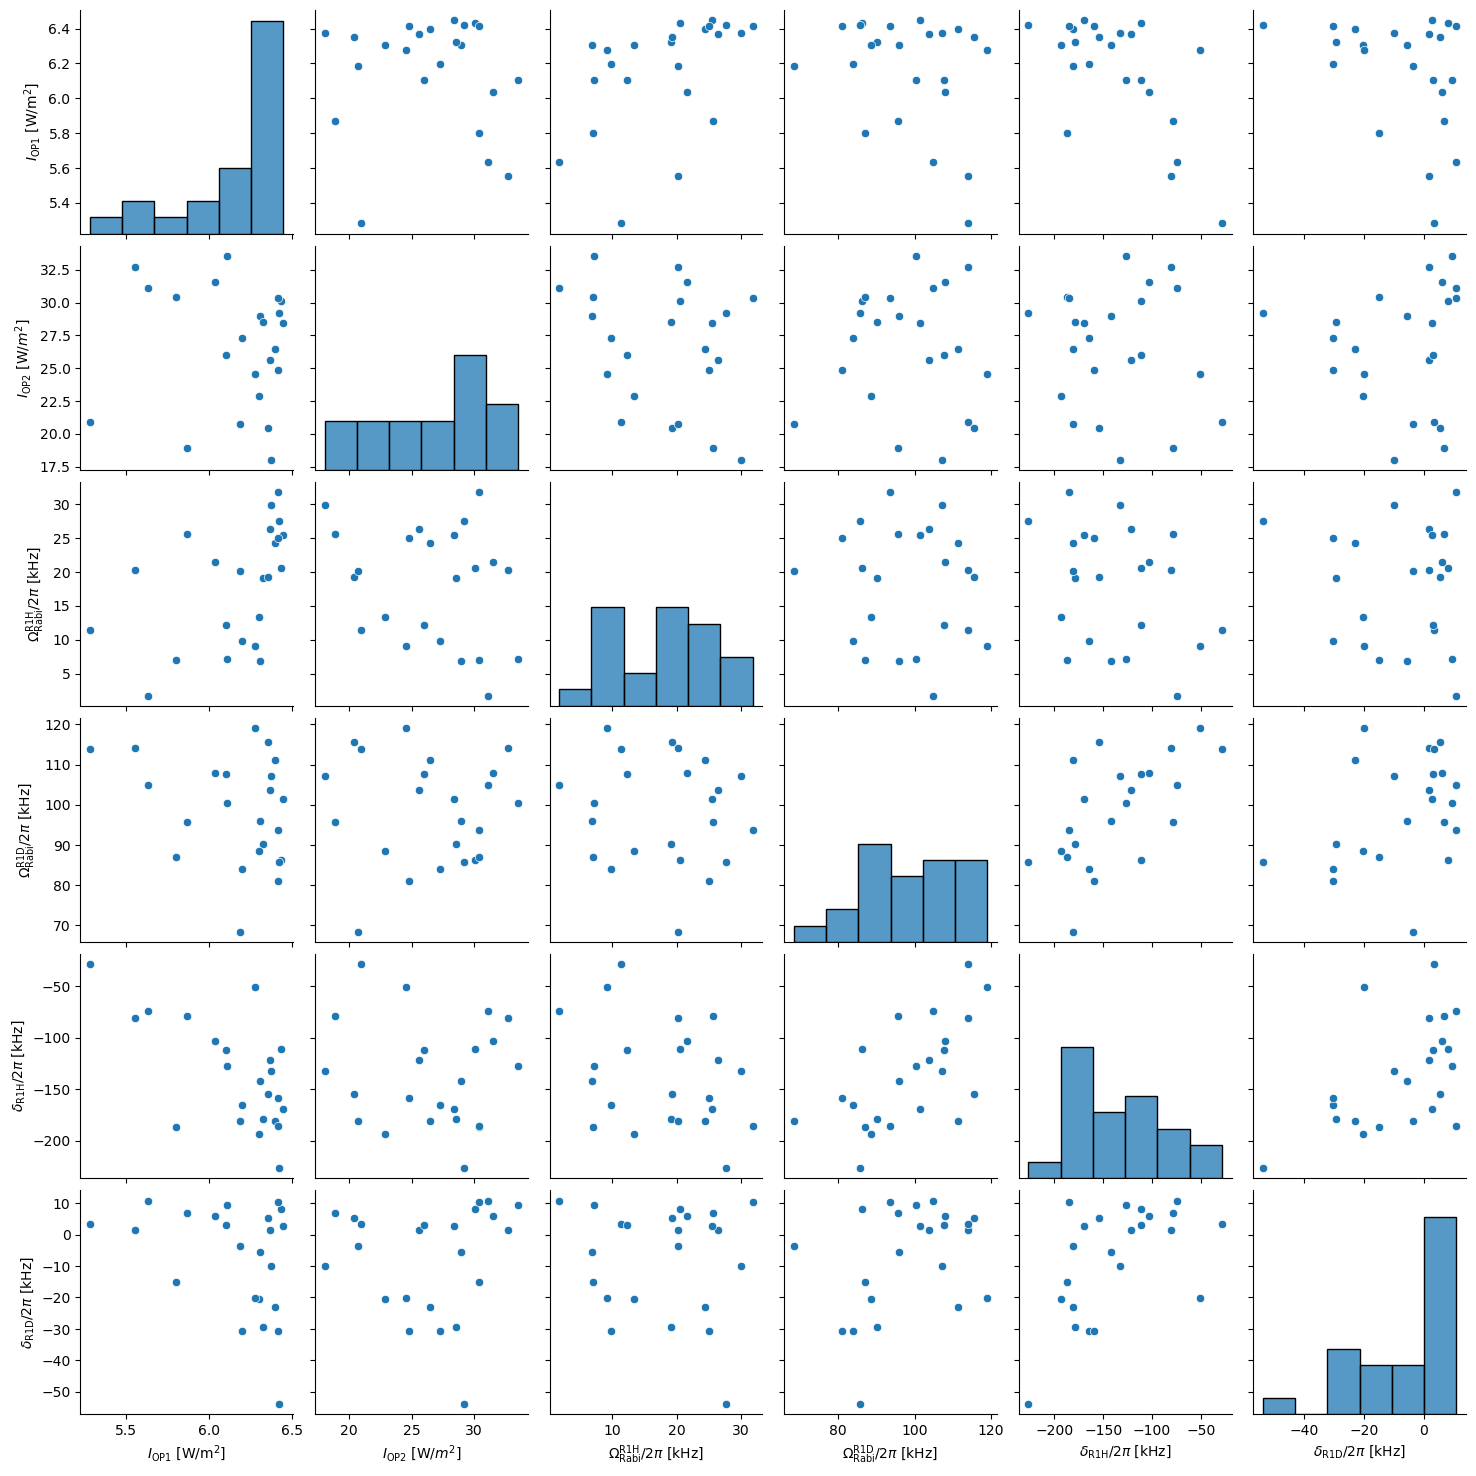

In [92]:
plt.figure(figsize=(11,11))
pair=sns.pairplot(newDataFrame)

plt.savefig("pair_plot_of_MLO_of_RSC.png")

## Plot results

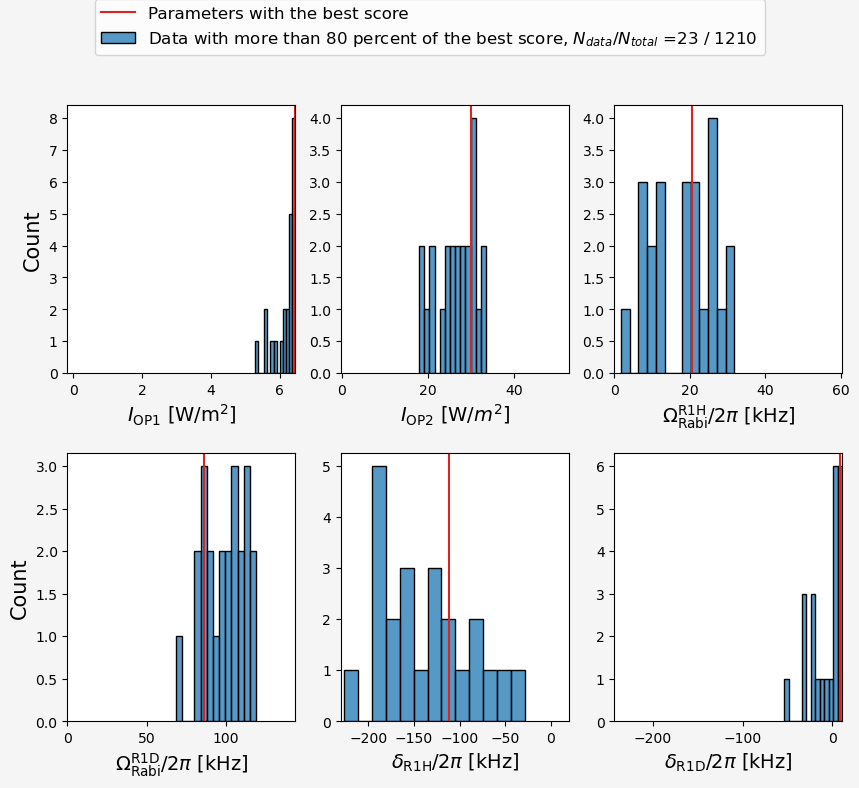

In [93]:
row_number = 2
column_number = 3
legend_label_1 = "Parameters with the best score"
legend_label_2 = r"Data with more than 80 percent of the best score, $N_{data} / N_{total}$ =%d / %d "%(len(dataAbove80PercentOfMaxScore), len(sortedData))

fig, axes = plt.subplots(row_number, column_number, figsize=(10,8),facecolor="whitesmoke")
plt.subplots_adjust(wspace=0.2, hspace=0.3)

names=(n1_name, n2_name, n3_name, n4_name, n5_name, n6_name)
limit=(n1_limit, n2_limit, n3_limit, n4_limit, n5_limit, n6_limit)

for i in range(row_number):
    for j in range(column_number):
        if column_number*i+j< column_number*row_number:
            sns.histplot(newDataFrame[names[(column_number*i+j)]], bins=13, ax=axes[i,j])
            axes[i,j].axvline(newDataFrame[names[column_number*i+j]].iloc[0],color='#dd2222',)
            axes[i,j].set_xlim(limit[column_number*i+j])
            axes[i,j].set_xlabel(names[column_number*i+j],fontsize=14)
            if j==0:
                axes[i,j].set_ylabel('Count',fontsize=15)
            else :
                axes[i,j].set_ylabel('',fontsize=14)

fig.legend(labels=[legend_label_1, legend_label_2],loc="upper center", borderaxespad=0,fontsize =12)

plt.savefig("hist_plot_of_MLO_of_RSC.png")

In [94]:
corr_matrix=newDataFrame.corr()
print(corr_matrix)

                                              $I_{\rm OP1}$ [W/m$^2$]  \
$I_{\rm OP1}$ [W/m$^2$]                                      1.000000   
$I_{\rm OP2}$ [W/$m^2$]                                     -0.061240   
$\Omega_{\rm Rabi}^{\rm R1H} / 2 \pi$ [kHz]                  0.471352   
$\Omega_{\rm Rabi}^{\rm R1D} / 2 \pi $ [kHz]                -0.297048   
$\delta_{\rm R1H}/ 2 \pi$ [kHz]                             -0.635392   
$\delta_{\rm R1D}/ 2\pi $ [kHz]                             -0.349401   

                                              $I_{\rm OP2}$ [W/$m^2$]  \
$I_{\rm OP1}$ [W/m$^2$]                                     -0.061240   
$I_{\rm OP2}$ [W/$m^2$]                                      1.000000   
$\Omega_{\rm Rabi}^{\rm R1H} / 2 \pi$ [kHz]                 -0.254159   
$\Omega_{\rm Rabi}^{\rm R1D} / 2 \pi $ [kHz]                -0.027609   
$\delta_{\rm R1H}/ 2 \pi$ [kHz]                             -0.100483   
$\delta_{\rm R1D}/ 2\pi $ [kHz]                   

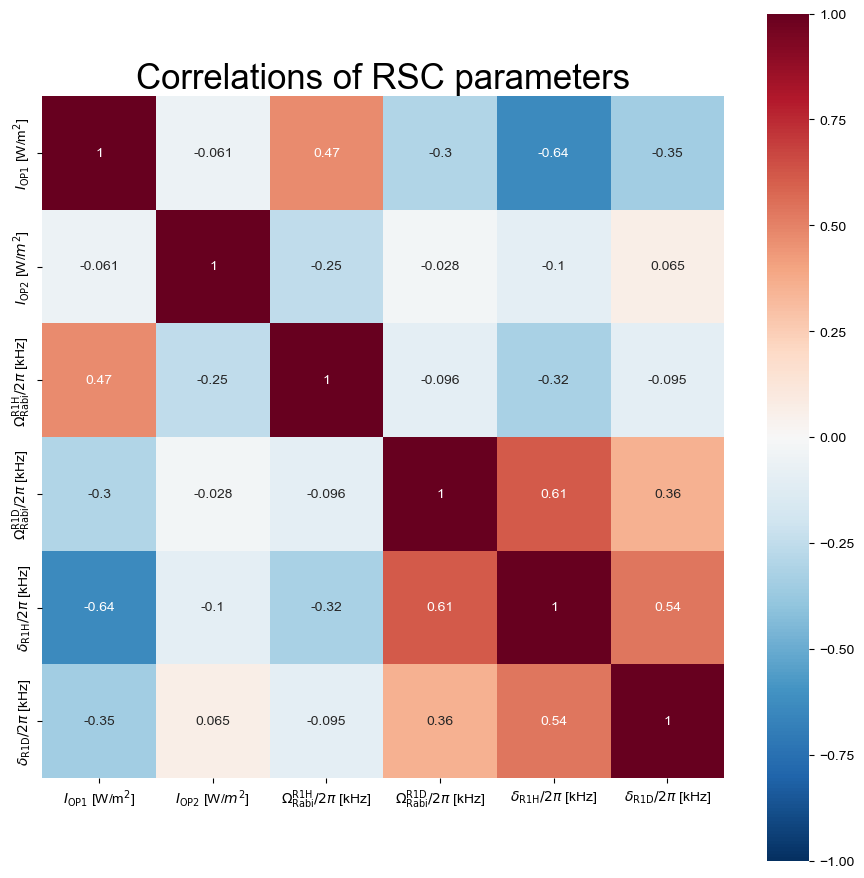

In [95]:
plt.figure(figsize=(11,11))
sns.heatmap(corr_matrix,square=True, cmap='RdBu_r',annot=True,vmin = -1, vmax = 1)
sns.set(font_scale=2)

plt.title('Correlations of RSC parameters', fontsize = 25) # title with fontsize 20
plt.savefig("correlation_plot_of_MLO_of_RSC.png")


In [96]:
FM_OP1 = scan_data["A0064: Raman repump 1: FM @ RSC"]
FM_OP2 = scan_data["A0062: Raman Repump 2: FM @ RSC"]

In [97]:
detuning_OP1 = voltage_to_detuning(FM_OP1,gradient_FM_OP1,offset_FM_OP1,resonance_OP1)[0]
detuning_OP2 = voltage_to_detuning(FM_OP2,gradient_FM_OP2,offset_FM_OP2,resonance_OP2)[0]

display(Math( r"\delta_{\rm OP1}/ 2\pi=%.01f {\rm MHz}"%(detuning_OP1*1e-3)))
display(Math( r"\delta_{\rm OP2}/ 2\pi=%.01f {\rm MHz}"%(detuning_OP2*1e-3)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>